# Импорт библиотек

In [1]:
import datetime
import itertools
import json
import pathlib
import warnings
from sklearn.ensemble import RandomForestClassifier
import eli5
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.linear_model as linear_model
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ARDRegression, ElasticNet, LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import ParameterGrid, GridSearchCV
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook as tqdm
from tsfresh import extract_features, extract_relevant_features
from tsfresh.feature_extraction import feature_calculators as fc
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns; sns.set()

import warnings; warnings.filterwarnings('ignore')

RS = 289475

Using TensorFlow backend.
D:\Programs\x64\Anaconda_3_2019_07\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


# Загрузка данных

In [4]:
train_target = pd.read_csv('pet_target_train.csv', index_col='date', parse_dates=['date'])
test_target = pd.read_csv('pet_test_timestamps.csv', index_col='date', parse_dates=['date'])

daily = pd.read_csv('pet_daily.csv', index_col='date', parse_dates=['date'])
weekly = pd.read_csv('pet_weekly.csv', index_col='date', parse_dates=['date'])

tsf_features2 = pd.read_csv('tsf_features2.csv', index_col='date', parse_dates=['date'])

print('train_target:', train_target.index.date.min(), '|', train_target.index.date.max())
print('test_target:', test_target.index.date.min(), '|', test_target.index.date.max())
print('daily:', daily.index.date.min(), '|', daily.index.date.max())
print('weekly:', weekly.index.date.min(), '|', weekly.index.date.max())
print('tsf_features2:', tsf_features2.index.date.min(), '|', tsf_features2.index.date.max())

train_target: 2004-06-01 | 2015-12-01
test_target: 2016-01-01 | 2019-07-01
daily: 2002-07-01 | 2019-06-28
weekly: 2004-04-30 | 2019-08-16
tsf_features2: 2002-07-01 | 2019-06-28


# Фичи

In [5]:
dfts = daily.resample('D').ffill()
wfts = weekly.resample('D').ffill()

fts = dfts.join(wfts).drop('pta_NEA_USD',axis=1)

fts

,brent_close,brent_open,brent_max,brent_min,USDCNY_close,USDCNY_open,USDCNY_max,USDCNY_min,paraxylene_CHN_USD,paraxylene_RT_USD,paraxylene_SEA_USD,ethylene_glycol_EU_EUR,ethylene_glycol_CHN_USD
date,,,,,,,,,,,,,
2002-07-01,25.64,25.50,25.72,25.39,8.2770,8.2770,8.2770,8.2770,NaN,NaN,NaN,NaN,NaN
2002-07-02,25.75,25.61,25.97,25.60,8.2769,8.2769,8.2769,8.2769,NaN,NaN,NaN,NaN,NaN
2002-07-03,25.84,25.73,25.96,25.52,8.2768,8.2768,8.2768,8.2768,NaN,NaN,NaN,NaN,NaN
2002-07-04,25.55,25.88,25.94,25.50,8.2767,8.2767,8.2767,8.2767,NaN,NaN,NaN,NaN,NaN
2002-07-05,25.73,25.65,25.75,25.42,8.2766,8.2766,8.2766,8.2766,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-24,64.86,65.50,65.79,64.08,6.8770,6.8736,6.8873,6.8700,832.0,725.0,822.0,522.5,536.0
2019-06-25,65.05,64.89,65.98,64.17,6.8798,6.8715,6.8851,6.8655,832.0,725.0,822.0,522.5,536.0
2019-06-26,66.49,65.80,66.85,65.60,6.8800,6.8876,6.8937,6.8658,832.0,725.0,822.0,522.5,536.0


## Rolling

In [6]:
PERIODS = [f'{d}D' for d in range(1,1096)] 
AGGREGATES = ['mean', 'median', 'std', 'max', 'min']

all_features = []

for period in tqdm(PERIODS):
    for agg in AGGREGATES:
        if agg!='mean' and period=='1D':
            continue
        rolling_features = fts.rolling(period).aggregate(agg)
        rolling_features.rename(lambda x: '_'.join([x, period, agg]), axis=1, inplace=True)
        all_features.append(rolling_features) # rolling_features[rolling_features.index.day==9]
        
all_features = pd.concat(all_features, axis=1)

all_features

,brent_close_1D_mean,brent_open_1D_mean,brent_max_1D_mean,brent_min_1D_mean,USDCNY_close_1D_mean,USDCNY_open_1D_mean,USDCNY_max_1D_mean,USDCNY_min_1D_mean,paraxylene_CHN_USD_1D_mean,paraxylene_RT_USD_1D_mean,...,brent_min_1095D_min,USDCNY_close_1095D_min,USDCNY_open_1095D_min,USDCNY_max_1095D_min,USDCNY_min_1095D_min,paraxylene_CHN_USD_1095D_min,paraxylene_RT_USD_1095D_min,paraxylene_SEA_USD_1095D_min,ethylene_glycol_EU_EUR_1095D_min,ethylene_glycol_CHN_USD_1095D_min
date,,,,,,,,,,,,,,,,,,,,,
2002-07-01,25.64,25.50,25.72,25.39,8.2770,8.2770,8.2770,8.2770,NaN,NaN,...,25.39,8.2770,8.2770,8.2770,8.2770,NaN,NaN,NaN,NaN,NaN
2002-07-02,25.75,25.61,25.97,25.60,8.2769,8.2769,8.2769,8.2769,NaN,NaN,...,25.39,8.2769,8.2769,8.2769,8.2769,NaN,NaN,NaN,NaN,NaN
2002-07-03,25.84,25.73,25.96,25.52,8.2768,8.2768,8.2768,8.2768,NaN,NaN,...,25.39,8.2768,8.2768,8.2768,8.2768,NaN,NaN,NaN,NaN,NaN
2002-07-04,25.55,25.88,25.94,25.50,8.2767,8.2767,8.2767,8.2767,NaN,NaN,...,25.39,8.2767,8.2767,8.2767,8.2767,NaN,NaN,NaN,NaN,NaN
2002-07-05,25.73,25.65,25.75,25.42,8.2766,8.2766,8.2766,8.2766,NaN,NaN,...,25.39,8.2766,8.2766,8.2766,8.2766,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-24,64.86,65.50,65.79,64.08,6.8770,6.8736,6.8873,6.8700,832.0,725.0,...,41.51,6.2690,6.2596,6.2703,6.2460,768.0,685.0,758.0,522.5,528.5
2019-06-25,65.05,64.89,65.98,64.17,6.8798,6.8715,6.8851,6.8655,832.0,725.0,...,41.51,6.2690,6.2596,6.2703,6.2460,768.0,685.0,758.0,522.5,528.5
2019-06-26,66.49,65.80,66.85,65.60,6.8800,6.8876,6.8937,6.8658,832.0,725.0,...,41.51,6.2690,6.2596,6.2703,6.2460,768.0,685.0,758.0,522.5,528.5


## Tsfresh

In [7]:
all_features = all_features.join(tsf_features2)
all_features

,brent_close_1D_mean,brent_open_1D_mean,brent_max_1D_mean,brent_min_1D_mean,USDCNY_close_1D_mean,USDCNY_open_1D_mean,USDCNY_max_1D_mean,USDCNY_min_1D_mean,paraxylene_CHN_USD_1D_mean,paraxylene_RT_USD_1D_mean,...,brent_min_1095D_peaks_300,USDCNY_close_1095D_peaks_300,USDCNY_open_1095D_peaks_300,USDCNY_max_1095D_peaks_300,USDCNY_min_1095D_peaks_300,paraxylene_CHN_USD_1095D_peaks_300,paraxylene_RT_USD_1095D_peaks_300,paraxylene_SEA_USD_1095D_peaks_300,ethylene_glycol_EU_EUR_1095D_peaks_300,ethylene_glycol_CHN_USD_1095D_peaks_300
date,,,,,,,,,,,,,,,,,,,,,
2002-07-01,25.64,25.50,25.72,25.39,8.2770,8.2770,8.2770,8.2770,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2002-07-02,25.75,25.61,25.97,25.60,8.2769,8.2769,8.2769,8.2769,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2002-07-03,25.84,25.73,25.96,25.52,8.2768,8.2768,8.2768,8.2768,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2002-07-04,25.55,25.88,25.94,25.50,8.2767,8.2767,8.2767,8.2767,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2002-07-05,25.73,25.65,25.75,25.42,8.2766,8.2766,8.2766,8.2766,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-24,64.86,65.50,65.79,64.08,6.8770,6.8736,6.8873,6.8700,832.0,725.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-25,65.05,64.89,65.98,64.17,6.8798,6.8715,6.8851,6.8655,832.0,725.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-26,66.49,65.80,66.85,65.60,6.8800,6.8876,6.8937,6.8658,832.0,725.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Сокращаем до 1 дня и сдвигаем

In [8]:
all_features = all_features[all_features.index.day==9]

all_features['prediction_date'] = (
    all_features.index + pd.TimedeltaIndex(all_features.index.days_in_month-8, unit='D'))

all_features

,brent_close_1D_mean,brent_open_1D_mean,brent_max_1D_mean,brent_min_1D_mean,USDCNY_close_1D_mean,USDCNY_open_1D_mean,USDCNY_max_1D_mean,USDCNY_min_1D_mean,paraxylene_CHN_USD_1D_mean,paraxylene_RT_USD_1D_mean,...,USDCNY_close_1095D_peaks_300,USDCNY_open_1095D_peaks_300,USDCNY_max_1095D_peaks_300,USDCNY_min_1095D_peaks_300,paraxylene_CHN_USD_1095D_peaks_300,paraxylene_RT_USD_1095D_peaks_300,paraxylene_SEA_USD_1095D_peaks_300,ethylene_glycol_EU_EUR_1095D_peaks_300,ethylene_glycol_CHN_USD_1095D_peaks_300,prediction_date
date,,,,,,,,,,,,,,,,,,,,,
2002-07-09,25.17,25.10,25.20,24.75,8.2766,8.2766,8.2766,8.2766,NaN,NaN,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2002-08-01
2002-08-09,25.11,24.95,25.20,24.75,8.2767,8.2767,8.2767,8.2767,NaN,NaN,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2002-09-01
2002-09-09,28.49,28.61,28.65,28.05,8.2770,8.2770,8.2770,8.2770,NaN,NaN,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2002-10-01
2002-10-09,28.13,28.09,28.40,27.87,8.2771,8.2771,8.2771,8.2771,NaN,NaN,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2002-11-01
2002-11-09,23.58,23.66,23.92,23.32,8.2770,8.2770,8.2770,8.2770,NaN,NaN,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2002-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-09,62.10,61.66,62.36,61.04,6.7448,6.7448,6.7448,6.7448,1099.0,1000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-03-01
2019-03-09,65.74,66.08,66.09,64.02,6.7216,6.7268,6.7278,6.7173,1116.0,1030.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-04-01
2019-04-09,70.61,71.19,71.34,70.30,6.7119,6.7127,6.7195,6.7079,1041.0,950.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-01


## Убираем бесполезные колонки

In [9]:
df = train_target.join(all_features.ffill().set_index('prediction_date'), how='outer')['2005-02':] #2004-06
df.index.name = 'date'

nulls = df[:'2015'].isna().sum().sort_values(ascending=False)
nulls_cols = nulls[nulls>0].index

inf = (df == np.inf).sum().sort_values(ascending=False)
inf_cols = inf[inf>0].index

zeros = df[:'2015'].sum().sort_values(ascending=False)
zeros_cols = zeros[zeros==0].index

non_unique_cols = []
for col in df.columns:
    if len(df[col].unique()) == 1:
        non_unique_cols.append(col)
        
FTS_COLS = [
    col for col in df.columns[1:] if
    col not in nulls_cols
    and col not in inf_cols
    and col not in zeros_cols
    and col not in non_unique_cols
]
TARGET = 'pet'

df = df[[TARGET] + FTS_COLS]
df

,pet,brent_close_1D_mean,brent_open_1D_mean,brent_max_1D_mean,brent_min_1D_mean,USDCNY_close_1D_mean,USDCNY_open_1D_mean,USDCNY_max_1D_mean,USDCNY_min_1D_mean,paraxylene_CHN_USD_1D_mean,...,paraxylene_CHN_USD_1095D_peaks_50,paraxylene_RT_USD_1095D_peaks_50,paraxylene_SEA_USD_1095D_peaks_50,ethylene_glycol_EU_EUR_1095D_peaks_50,ethylene_glycol_CHN_USD_1095D_peaks_50,paraxylene_CHN_USD_1095D_peaks_100,paraxylene_RT_USD_1095D_peaks_100,paraxylene_SEA_USD_1095D_peaks_100,ethylene_glycol_EU_EUR_1095D_peaks_100,ethylene_glycol_CHN_USD_1095D_peaks_100
date,,,,,,,,,,,,,,,,,,,,,
2005-02-01,1235.00,43.18,42.75,43.75,42.20,8.2765,8.2765,8.2765,8.2765,955.0,...,0.0,7.0,0.0,6.0,7.0,0.0,0.0,0.0,0.0,0.0
2005-03-01,1271.25,43.04,43.70,43.87,42.76,8.2765,8.2765,8.2765,8.2765,965.0,...,0.0,7.0,0.0,6.0,7.0,0.0,0.0,0.0,0.0,0.0
2005-04-01,1242.00,53.38,52.80,54.30,52.67,8.2765,8.2765,8.2765,8.2765,985.0,...,0.0,7.0,0.0,6.0,7.0,0.0,0.0,0.0,0.0,0.0
2005-05-01,1122.50,52.89,53.40,53.90,52.58,8.2765,8.2765,8.2765,8.2765,955.0,...,0.0,7.0,0.0,6.0,7.0,0.0,0.0,0.0,0.0,0.0
2005-06-01,1060.00,51.29,51.40,51.60,50.41,8.2765,8.2765,8.2765,8.2765,795.0,...,0.0,13.0,0.0,9.0,14.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-01,NaN,62.10,61.66,62.36,61.04,6.7448,6.7448,6.7448,6.7448,1099.0,...,21.0,28.0,21.0,41.0,13.0,7.0,14.0,0.0,19.0,7.0
2019-04-01,NaN,65.74,66.08,66.09,64.02,6.7216,6.7268,6.7278,6.7173,1116.0,...,21.0,28.0,21.0,41.0,13.0,7.0,7.0,0.0,19.0,7.0
2019-05-01,NaN,70.61,71.19,71.34,70.30,6.7119,6.7127,6.7195,6.7079,1041.0,...,14.0,28.0,14.0,41.0,13.0,7.0,7.0,0.0,19.0,7.0


## Считаем корреляцию

In [10]:
tr_df = df[:'2015']
corrs = tr_df[FTS_COLS].corrwith(tr_df[TARGET]).abs().sort_values(ascending=False)
corrs

paraxylene_RT_USD_2D_max               0.824441
paraxylene_RT_USD_7D_quantile_0.2      0.823821
paraxylene_RT_USD_4D_min               0.823762
paraxylene_RT_USD_5D_min               0.823491
paraxylene_RT_USD_7D_quantile_0.1      0.823416
                                         ...   
ethylene_glycol_CHN_USD_794D_std       0.000073
ethylene_glycol_CHN_USD_678D_median    0.000039
ethylene_glycol_EU_EUR_729D_mean       0.000033
ethylene_glycol_CHN_USD_224D_std       0.000023
ethylene_glycol_CHN_USD_245D_std       0.000013
Length: 75914, dtype: float64

# ElasticNet

In [11]:
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_pred-y_true)/y_true)) * 100, 4)

def line_model(model, df, sli, params, corr_rank=None):
    full_df, tr, cv = df[:'2015'].copy(), df[:str(sli)].copy(), df[str(sli+1):'2015'].copy()
    print('Start:', tr.shape, cv.shape)
    
    corrs_cols = corrs[corrs <= corr_rank].index
    print('Del corr cols:', len(corrs_cols))
    
    del_cols = list(corrs_cols) + [TARGET]
    FCOLS = [col for col in full_df.columns if col not in del_cols]
    print('After:', tr[FCOLS].shape, cv[FCOLS].shape)
    
    errors = []
    for param in tqdm(params):
        lmodel = eval(model)(**param)
        lmodel.fit(tr[FCOLS], tr[TARGET])

        ltr_preds = pd.Series(lmodel.predict(tr[FCOLS]), index=tr.index)
        lcv_preds = pd.Series(lmodel.predict(cv[FCOLS]), index=cv.index)

        cv_mape = mape(cv[TARGET], lcv_preds)
        errors.append({
            'mape': cv_mape,
            'param': param
        })

    errors = pd.DataFrame.from_records(errors)
    min_error = errors.iloc[errors['mape'].idxmin()]
    print(min_error['mape'], min_error['param'])
    
    lmodel = eval(model)(**min_error['param'])
    lmodel.fit(tr[FCOLS], tr[TARGET])
    
    ltr_preds = pd.Series(lmodel.predict(tr[FCOLS]), index=tr.index)
    lcv_preds = pd.Series(lmodel.predict(cv[FCOLS]), index=cv.index)

    plt.figure(figsize=(18,6))
    sns.lineplot(data=df, x=df.index ,y=TARGET, label='Full')
    sns.lineplot(x=ltr_preds.index ,y=ltr_preds.values, label='Train_pred')
    sns.lineplot(x=lcv_preds.index ,y=lcv_preds.values, label='Valid_pred', c='red')
    plt.title(model.split('.')[1])
    plt.xlabel('Date'); plt.ylabel('Prices')
    
    f_lmodel = eval(model)(**min_error['param'])
    f_lmodel.fit(full_df[FCOLS], full_df[TARGET])
    
    return lmodel, f_lmodel, FCOLS

Start: (119, 75915) (12, 75915)
Del corr cols: 71155
After: (119, 4759) (12, 4759)



5.6583 {'alpha': 0.1, 'fit_intercept': False, 'l1_ratio': 0.5, 'max_iter': 50, 'positive': True, 'precompute': True, 'selection': 'random', 'tol': 0.01, 'warm_start': False}


Weight?,Feature
+2.282,brent_close_59D_median
+0.049,ethylene_glycol_CHN_USD_7D_quantile_0.2
+0.030,ethylene_glycol_CHN_USD_2D_min
+0.029,ethylene_glycol_CHN_USD_7D_min
+0.029,ethylene_glycol_CHN_USD_5D_min
+0.025,ethylene_glycol_CHN_USD_7D_quantile_0.4
+0.022,ethylene_glycol_CHN_USD_3D_median
+0.021,ethylene_glycol_CHN_USD_2D_mean
+0.021,ethylene_glycol_CHN_USD_4D_min
+0.019,ethylene_glycol_CHN_USD_3D_max


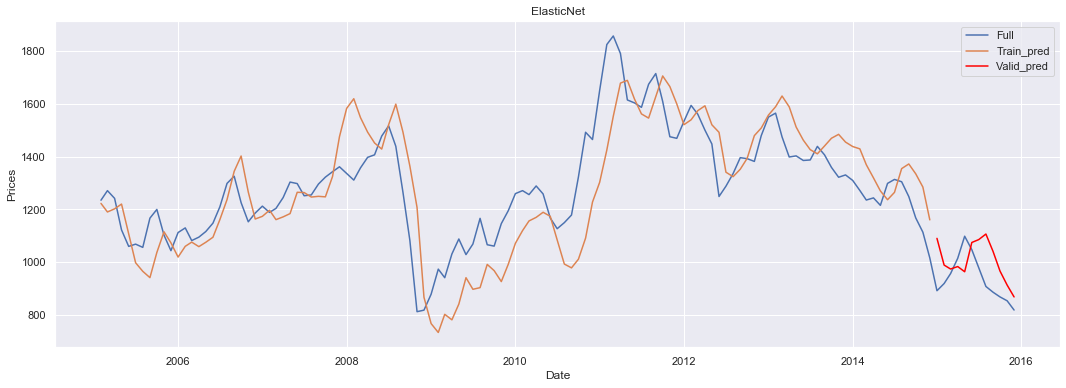

In [12]:
params = ParameterGrid({
    'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 2, 3, 4], 
    'l1_ratio': [0.1, 0.5, 1, 3, 5],
    'positive': [True,False],
    'max_iter': [10, 15, 20, 50, 100, 200], # , 100, 200, 300, 500
    'precompute': [True,False],
    'warm_start': [True,False],
    #'normalize': [True,False],
    'selection': ['cyclic','random'],
    'tol': [0.01, 0.001, 0.0001],
    'fit_intercept': [True,False]
})

lmodel, f_lmodel, FCOLS = line_model(
    'linear_model.ElasticNet', df, 2014, params, corr_rank=0.6)

eli5.show_weights(f_lmodel, top=15, feature_names=FCOLS)

## _Предсказание

In [14]:
ts = df['2016':].copy()
predict_f = f_lmodel.predict(ts[FCOLS])
ts_preds = pd.DataFrame(predict_f, columns=['pet'], index=ts.index)
ts_preds.loc[test_target.index].to_csv('submit_model3')#('sub/pet_linear_35_11.csv')

# Сравнение

In [16]:
# def mape(y_true, y_pred): return 100 * np.mean(np.abs((y_pred-y_true)/y_true))
# s_1 = pd.read_csv('sub\pet_linear_35.csv', index_col=0, parse_dates=["date"])
# s_2 = pd.read_csv('sub\pet_linear_35_10.csv', index_col=0, parse_dates=["date"])
# print('mape =',mape(s_1['pet'].values,   s_2['pet'].values))